In [1]:
import os
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BMonthEnd
import pymssql
import beatbox
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline 

In [2]:
import seaborn as sns
sns.set_style('whitegrid')
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import colorlover as cl
from IPython.display import HTML

In [3]:
plotly.tools.set_credentials_file(username='Gabrielle.Agrocostea', api_key='Cb1kH6PHRhg7D8HyN1Bn')
plotly.tools.set_config_file(world_readable=False, sharing='secret')

In [4]:
def login_salesforce():
    '''
    
    :return: connection to SalesForce backup database using pymssql (mssql)
    '''
    server = "10.0.123.212"
    user = "dbamp"
    password = "ua4yCAnolhxV"
    conn = pymssql.connect(server, user, password, "salesforce backups")
    return conn


def get_column_headers(cursor):
    '''

    :param cursor: mySQL cursor with query that has been executed
    :return: column headers based on query
    '''
    col_headers = list(cursor.description)
    col_headers = [x[0] for x in col_headers]
    return col_headers

def get_SF_data(query_string, connection):
    cursor = connection.cursor()
    # Execute query to obtain opportunity data
    cursor.execute(query_string)
    qr_results = cursor.fetchall()
    # get column headers
    headers = get_column_headers(cursor)
    # put in DataFrame
    df = pd.DataFrame(data=qr_results, columns=headers)
    return df

# query for exchange rates
def get_exchange_df(connection):
    cursor = connection.cursor()
    exchangeRates = "select dc.ConversionRate, dc.IsoCode, dc.StartDate, dc.NextStartDate "
    exchangeRates += "from dbo.DatedConversionRate dc"
    cursor.execute(exchangeRates)
    rates_res = cursor.fetchall()
    # put in DataFrame
    rates = pd.DataFrame(data=rates_res, columns=get_column_headers(cursor))
    return rates

def get_object_fields(svc, sf_object):
    '''
    function to get SalesForce object fields
    :param svc: beatbox connection
    :param sf_object: object to get description
    :return: list of column names

    ex: obj_desc = svc.describeSObjects("Conversion_Rate__c")
    '''

    obj_desc = svc.describeSObjects(sf_object)[0]
    names = [name for name in obj_desc.fields]
    return names

def get_opportunity_df(connection):
    '''
    Function used to query opportunity data for opportunity snapshots
    Query all new & existing opportunities, join with User table
    :param connection: pymysql open connection to SalesForce
    :return: DataFrame with opportunity & owner data
    '''
    q = "SELECT o.Services_Total__c, o.CreatedDate as Created_Date__c, Maintenance_ARR_Delta__c, o.ARR_Delta__c, "
    q += "u.Name as Opportunity_Owner__c, Account_Industry__c as Industry__c, a.Name as Account_Name__c, "
    q += "o.Id as Opportunity_ID__c, o.Cloud_Total__c, o.Probability as Probability__c, o.CurrencyIsoCode, "
    q += "o.Subscription_Total__c, o.Maintenance_Total__c, o.StageName as Stage__c, o.Amount as Amount__c, "
    q += "NextStep Next_Step__c, o.Name as Opportunity_Name__c, "
    q += "Subscription_ARR_Delta__c, Cloud_ARR_Delta__c, o.Type as Type__c, "
    q += "o.CloseDate as Close_Date__c, o.Previous_Stage__c as Prev_Stage__c, o.Region__c, "
    q += "u1.Name as Created_By__c, License_Total__c, o.Date_Opp_Moved_40__c  "
    q += "from dbo.Opportunity o "
    q += "join dbo.[User] u "
    q += "on o.OwnerId = u.Id "
    q += "join dbo.Account a "
    q += "on o.AccountId = a.Id "
    q += "join dbo.[User] u1 "
    q += "on o.CreatedById = u1.Id "
    q += "where o.Type in ('New Business','Existing Business');"
    cursor = connection.cursor()
    # Execute query to obtain opportunity data
    cursor.execute(q)
    qr_res = cursor.fetchall()
    # get column headers
    headers = get_column_headers(cursor)
    # put in DataFrame
    df = pd.DataFrame(data=qr_res, columns=headers)
    return df


## TODO: merge based on startdate and enddate
def lookup_rates(cur, close_date, rates_df, rates_dict):
    from datetime import datetime as dt
    '''
    Function to lookup exchange rates, based on currency code & close date
    Need to pass in latest exchange rates (rates_df) and current rates (rates_dict)
        If opportunity close date is in current month or in the future, use current rates
        Else: use past currency rates

    :param cur: currency, string ('USD','GBP')
    :param close_date: datetime.date. Close date of opportunity
    :param rates_df: DataFrame with exchange rates (past rates)
    :param rates_dict: dictionary with today's rates {IsoCode: exchange rate}
    :return: exchange rate
    '''
    today = dt.today().date()
    offset = BMonthEnd()
    first_day = offset.rollback(today).date()
    last_day = offset.rollforward(today).date()

    # EUR is always 1.0
    if cur == 'EUR':
        return 1.0
    # if close date is in future: use current rates
    elif close_date > today:
        return float(rates_dict['ConversionRate'][cur])
    # if close date is in past:
        # find rate where the date is in between startdate & next start date
        # or use present rate
    elif close_date < today:
        rate = rates_df[(rates_df.IsoCode ==cur)&(rates_df.NextStartDate > close_date) & (rates_df.StartDate <= close_date)].ConversionRate
        if len(rate) ==0:
            return float(rates_dict['ConversionRate'][cur])
        else:
            return float(rate)

def opp_age(stage, createdDate, closeDate):
    '''
    Function to calculate the age of an opportunity
        If opp is closed, age = closed date - created date
        Else: age = today - created date
    :param stage: str, StageName
    :param createdDate: datetime
    :param closeDate: datetime
    :return: integer
    '''
    closed = 'Closed' in stage
    if closed:
        age = closeDate - createdDate
    else:
        age = dt.today().date() - createdDate
    return age.days

def query_data_bb(svc, query_string):
    """
    Function using BeatBox to query data and return results for any query

    :param svc: beatbox connection
    :param query_string: query string
    :return: list with data
    """
    record_list = []

    query_res = svc.query(query_string)
    record_list += query_res['records']

    # if need to get more records
    while not query_res.done:
        print " ******** FETCHING MORE DATAS ********"
        query_res = svc.queryMore(query_res.queryLocator)
        record_list += query_res
    # df = pd.DataFrame(data=record_list)
    # df.columns = df.columns.map(lambda x: x.replace("__c", "").replace("_", ""))

    return record_list

def millions(x, pos):
    'The two args are the value and tick position'
    # use like this in matplotlib
    # formatter = FuncFormatter(millions)
#    return '€%1.1fM' % (x*1e-6)
    return '%1.1fM' % (x*1e-6)



In [5]:
stages = ['Prospect', 'Qualified', 'Buying Process id.', 'Short List', 'Chosen Vendor', 'Negotiation/Review',
          'PO In Progress', 'Closed Won']
lost = ['Closed Deferred', 'Closed Lost']
# open stages
stages_open = list(set(stages) - set(lost) - set(['Closed Won']))

not_pipeline = ['Qualified','Qualification','Prospect','Re-Qualify']

# dict to order stages
stage_order = dict(zip(stages, xrange(0, len(stages))))

industry_map = {
    "Asset Management": "Financial Services",
    "Banking": "Financial Services",
    "Insurance": "Financial Services",
    "Financial Services: Other": "Financial Services",
    "Healthcare Payer": "Healthcare",
    "Healthcare Provider": "Healthcare",
    "Healthcare Payer and Provider": "Healthcare",
    "Technology": "Technology",
    "Government: Federal": "Federal",
    "Government": "Federal",
    "Government: State and Local": "Federal",
    "Life Sciences": "Life Sciences"}


# reporting dates for board reports - when opportunity Snapshot was run
rpt_dates_1 = ['10-15-2015','1-14-2016','4-14-2016','7-14-2016','10-14-2016','1-13-2017','4-14-2017','7-14-2017']
rpt_dates_1 = [pd.to_datetime(x) for x in rpt_dates_1]
rpt_dates_1 = [x.date() for x in rpt_dates_1]
rpt_dates_2 =['10-1-2015','11-5-2015','12-3-2015','1-7-2016','2-4-2016','3-3-2016','4-7-2016','5-5-2016','6-2-2016',
             '7-7-2016','8-5-2016','9-2-2016','10-7-2016','11-4-2016','12-2-2016','1-6-2017','2-3-2017','3-3-2017','4-7-2017',
             '5-5-2017','6-2-2017','7-7-2017','8-4-2017','9-1-2017']
rpt_dates_2 = [pd.to_datetime(x) for x in rpt_dates_2]
rpt_dates_2 = [x.date() for x in rpt_dates_2]

# dictionary with quarterly reporting dates
qt_rpt_dates = {
    pd.Period('2017Q1', freq = 'Q-SEP'):pd.to_datetime('2016-10-14').date(),
    pd.Period('2017Q2', freq = 'Q-SEP'):pd.to_datetime('2017-01-13').date(),
    pd.Period('2017Q3', freq = 'Q-SEP'):pd.to_datetime('2017-04-14').date(),
    pd.Period('2017Q4', freq = 'Q-SEP'):pd.to_datetime('2017-07-14').date()
}

qt_start_end_dates = {
    pd.Period('2017Q1', freq = 'Q-SEP'): [pd.to_datetime('2016-10-01').date(), pd.to_datetime('2016-12-31').date()],
    pd.Period('2017Q2', freq = 'Q-SEP'): [pd.to_datetime('2017-01-01').date(), pd.to_datetime('2017-03-31').date()],
    pd.Period('2017Q3', freq = 'Q-SEP'): [pd.to_datetime('2017-04-01').date(), pd.to_datetime('2017-06-30').date()],
    pd.Period('2017Q4', freq = 'Q-SEP'): [pd.to_datetime('2017-07-01').date(), pd.to_datetime('2017-09-30').date()]
}



# Field Event - leave as is bc John didnt update in SF per Marketing request to leave as is
lead_mapping = {'Rep List': 'Sales Rep',
                'Rep Sourced Social': 'SDR'}  #, 'Field Event':'Collibra Event'}

# Sales and Marketing sources
lead_source_mapping ={
    'Advertisement': 'Marketing', # this shouldnt be used anymore - old
    'Content Syndication': 'Marketing',
    'Direct Mail': 'Marketing',
    'Email': 'Marketing',
    'Field Event' : 'Marketing',
    'Paid Search': 'Marketing',
    'RainKing':'Marketing', # this shouldnt be used anymore - old
    'Seminar/Conference': 'Marketing',
    'Social Media': 'Marketing',
    'TechTarget': 'Marketing',
    'Webinar': 'Marketing',
    'Website': 'Marketing',
    'Database': 'Sales',  # this shouldnt be used anymore - old
    'External Referral': 'Sales', # this shouldnt be used anymore - old
    'Jigsaw': 'Sales',  # this shouldnt be used anymore - old
    'Partner': 'Sales',
    'Other': 'Sales', # this shouldnt be used anymore - old
    'Sales Operations':'Sales',
    'Sales Rep':'Sales',
    'SDR':'Sales',
    'University':'tbd'}

# these are the marketing sources - anything else is other
marketing_sources = ['Seminar/Conference', 'Website','Content Syndication', 'Paid Search',
                     'Webinar','Email','Field Event','Social Media']

In [6]:
project_path = '/Users/Gabi/Documents/projects/reporting/'
data_path = '/Users/Gabi/Documents/projects/reporting/data'

In [7]:
os.chdir(project_path)

In [8]:
# connect to SalesForce
conn_SF = login_salesforce()

In [9]:
'''
    1 - Opportunity Snapshot Data: New and Existing Business Open Opportunities (Not Closed/Not won)
    Objects used: Opportunitiy Snapshot
'''

q_snap = "Select o.Report_Date__c, o.Stage__c, o.Amount__c, ARR_Delta_EURO__c, o.Type__c, o.Close_Date__c, o.Industry__c, "
q_snap += "Created_Date__c, CurrencyIsoCode, Date_Opp_Moved_40__c, Opportunity_ID__c "
q_snap += "from dbo.Opportunity_Snapshot__c o "
q_snap += "where o.Type__c in ('New Business','Existing Business') "
q_snap += "and o.Stage__c not in ('Closed Won','Closed Lost','Closed Deferred','Re-Qualify');"

# get Opportunity Snapshot - SF backup data
df_snap = get_SF_data(connection=conn_SF, query_string=q_snap)

In [10]:
'''
    2 - Lead Data: Sales Sourced Leads & Marketing Sourced Leads
    Objects used:  Lead
'''
# get Lead data - SF backup data
q_leads =  "select l.leadSource, l.CreatedDate, l.title_Score__c, l.Managed_By__c from dbo.Lead as l"

# run query for Lead Data
df_leads = get_SF_data(connection=conn_SF, query_string=q_leads)

# get Marketing Sourced Lead Data - replicate of: Board Reporting: Marketing Sourced Leads
q_marketing = "select l.leadSource, l.CreatedDate, l.title_Score__c, l.Managed_By__c from dbo.Lead as l "
q_marketing += "where l.leadSource not in ('Partner','Rep List','Sales Rep','External Referral','Rep Sourced Social','SDR','Sales Operations') "
q_marketing += "and l.leadSource <> '';"

# run query for Marketing Sourced Lead Data
df_mk = get_SF_data(connection=conn_SF, query_string=q_marketing)


# get Sales Sourced Lead Data - replicate of: Board Reporting: Sales Sourced Leads
q_sales = "select l.leadSource, l.CreatedDate, l.title_Score__c, l.Managed_By__c from dbo.Lead as l "
q_sales += "where l.leadSource in ('Partner','Rep List','Sales Rep','External Referral','Rep Sourced Social','SDR','Sales Operations') "
q_sales += "and l.leadSource <> '';"

# run query for Sourced Lead Data
df_sales = get_SF_data(connection=conn_SF, query_string=q_sales)


In [11]:
'''
    3 - Pipeline Generation - Leads created by SDR's with opportunities attached
    Objects used: Task, Opportunities, User
    *** Leadsource may need to be updated - this uses Opportunity Lead Source, the board report uses Contact Role Lead Source
'''

q_pipe = "select u1.Name as CreatedBy, u2.Name as AccountOwner, t.ActivityDate as StartDate, "
q_pipe += "o.Name as OpportunityName,  t.AccountId, t.Attach_to_an_Existing_Opportunity__c, o.Id as OpportunityId, "
q_pipe += "o.LeadSource, o.Type, o.StageName, o.New_ARR__c, o.CreatedDate, o.CloseDate "
q_pipe += "from dbo.Task as t "
q_pipe += "inner join dbo.Opportunity as o "
q_pipe += "on o.Id = t.WhatID "
q_pipe += "inner join dbo.[User] as u1 "
q_pipe += "on t.CreatedById = u1.Id  " #--SDR Created
q_pipe += "inner join dbo.[User] as u2 "
q_pipe += "on o.OwnerId = u2.Id " #-- Acct Owner
q_pipe += "where t.Type = 'Product Intro' "  # API name hasnt changed to discovery call
q_pipe += "and t.Created_by_Division__c = 'SDR' "
q_pipe += "and o.Name != '' "
q_pipe += "and t.Status != 'Deferred' "
q_pipe += "and t.ActivityDate >='2016-04-01' "
q_pipe += "and t.ActivityDate <= GetDate(); "

# get Pipeline Generation data - SF backup data
df_pipe = get_SF_data(connection=conn_SF, query_string=q_pipe)

In [12]:
'''
    4) Opportunity Data - New and Exisiting Opportunities
    Objects used: Opportunity, User
'''

q_opps = "select u1.Name as AccountOwner, o.Name as OpportunityName, o.Id as OpportunityId, o.Account_Industry__c, "
q_opps += "o.LeadSource, o.Type, o.StageName, o.New_ARR__c, o.New_ARR_EURO__c,o.CreatedDate, o.CloseDate "
q_opps += "from dbo.Opportunity as o "
q_opps += "inner join dbo.[User] as u1 "
q_opps += "on o.OwnerId = u1.Id " #-- Acct Owner
q_opps += " where o.Type in ('New Business','Existing Business')"

# get Pipeline Generation data - SF backup data
df_opps = get_SF_data(connection=conn_SF, query_string=q_opps)

In [13]:
'''
    5) Conversion Rates Data - New Business
    Objects used: Conversion Rate
'''

# q_convrates = "select * from dbo.Conversion_Rate__c"

q_convrates = "select cv.FromDate__c, cv.ToDate__c, cv.FromStage__c, cv.ConversionRate__c, "
q_convrates += "cv.Numerator__c, cv.Denominator__c, cv.ToStage__c, cv.ReportDate__c "
q_convrates += "from dbo.Conversion_Rate__c as cv;"

# get Pipeline Generation data - SF backup data
df_convrates = get_SF_data(connection=conn_SF, query_string=q_convrates)

In [14]:
''' ################## DONT NEED THIS!! ##################
    6 - Opportunity Snapshot Data: New and Existing Business Open Opportunities Closed Won
    Objects used: Opportunitiy Snapshot
'''

q_snap_closed = "Select o.Report_Date__c, o.Stage__c, o.Amount__c, ARR_Delta_EURO__c, o.Type__c, o.Close_Date__c, o.Industry__c, "
q_snap_closed += "Created_Date__c, CurrencyIsoCode, Date_Opp_Moved_40__c, Opportunity_ID__c "
q_snap_closed += "from dbo.Opportunity_Snapshot__c o "
q_snap_closed += "where o.Type__c in ('New Business','Existing Business') "
q_snap_closed += "and o.Stage__c = 'Closed Won';"

# get Opportunity Snapshot - SF backup data
df_snap_closed = get_SF_data(connection=conn_SF, query_string=q_snap_closed)

In [15]:
# close connection to SalesForce
conn_SF.close()

### Opportunity Snapshot Data Cleaning and Pre-processing:
* Clean industry
* Include snapshots dates from Board report
* add Fiscal Year

#### Filters: 
* Exclude Closed Won, Closed Lost/Deferred, Re-Qualify

In [16]:
'''
    1 - Opportunity Snapshot Data Pre-processing:
        Clean industry, include snapshots dates from Board report, add Fiscal Year
        Filters: Exclude Closed Won, Closed Lost/Deferred, Re-Qualify
'''
# clean up industry
df_snap['grouped_industry'] = df_snap.Industry__c.map(lambda  x: industry_map.get(x,'Other'))
# clean up date columns
date_cols = ['Created_Date__c', 'Close_Date__c','Report_Date__c']
df_snap[date_cols] = df_snap[date_cols].applymap(lambda x: np.datetime64(x))

# clean up numeric columns
numeric_cols = ['Amount__c','ARR_Delta_EURO__c']
df_snap[numeric_cols] = df_snap[numeric_cols].fillna(0.0)
df_snap[numeric_cols] = df_snap[numeric_cols].applymap(lambda x: np.float(x))

# create periods
monthly_periods = pd.period_range(df_snap.Report_Date__c.min(),df_snap.Report_Date__c.max(), freq='M')
quarter_periods = pd.period_range(df_snap.Report_Date__c.min(),df_snap.Report_Date__c.max(), freq='Q-SEP')
# add in Fiscal Quarter and Month
df_snap['quarter'] = df_snap.Report_Date__c.dt.to_period('Q-SEP')
df_snap['month'] = df_snap.Report_Date__c.dt.to_period('M')

# Filter out Closed Won, Closed Lost and Closed Deferred
df_snap = df_snap[~(df_snap.Stage__c.isin(['Closed Won','Closed Lost','Closed Deferred']))]
# Clean up old stage data
df_snap.Stage__c.replace('Qualification', 'Qualified', inplace = True)
df_snap = df_snap[df_snap.Stage__c != 'Re-Qualify']

rpt_dates_1 = ['10-15-2015','1-14-2016','4-14-2016','7-14-2016','10-14-2016','1-13-2017','4-14-2017','7-14-2017']
rpt_dates_1 = [pd.to_datetime(x) for x in rpt_dates_1]
rpt_dates_1 = [x.date() for x in rpt_dates_1]
rpt_dates_2 =['10-1-2015','11-5-2015','12-3-2015','1-7-2016','2-4-2016','3-3-2016','4-7-2016','5-5-2016','6-2-2016',
             '7-7-2016','8-5-2016','9-2-2016','10-7-2016','11-4-2016','12-2-2016','1-6-2017','2-3-2017','3-3-2017','4-7-2017',
             '5-5-2017','6-2-2017','7-7-2017','8-4-2017','9-1-2017']
rpt_dates_2 = [pd.to_datetime(x) for x in rpt_dates_2]
rpt_dates_2 = [x.date() for x in rpt_dates_2]
# Filter out dates
df_snap = df_snap[(df_snap.Report_Date__c.isin(rpt_dates_1)) | (df_snap.Report_Date__c.isin(rpt_dates_2))]
# add order for stage sorting
df_snap['stage_order'] = df_snap.Stage__c.map(lambda x : stage_order.get(x))



### Lead Data Cleaning and Pre-processing:
* Add in Fiscal Quarter and Year
* Clean up Marketing Sources
* Clean up lead sources (based on recent updates made by Erica)
* Split up leads: Sales, Reseller

In [17]:
'''
    2 - Lead Data Pre-processing:
        Clean up Marketing Lead Data
        Clean up Sales Lead Data        
'''
# clean up Created date
df_leads.CreatedDate = df_leads.CreatedDate.map(lambda x: np.datetime64(x))
# add in Fiscal Quarter and Month based on Created Date
df_leads['quarter'] = df_leads.CreatedDate.dt.to_period('Q-SEP')
df_leads['month'] = df_leads.CreatedDate.dt.to_period('M')

df_leads['source'] = df_leads.leadSource.map(lambda x: lead_source_mapping.get(x,'Old'))
# this is the updated lead sources based on updates made by Erica
df_leads['updated_leadSource'] = df_leads.leadSource
df_leads.updated_leadSource = df_leads.updated_leadSource.replace({'Rep List':'Sales Rep',
                                    'Rep Sourced Social':'SDR'} , axis=0) # ,'Field Event':'Collibra Event'}, axis=0)
# add lead source - Marketing, Sales, Other
df_leads['lead_source'] = df_leads.updated_leadSource.map(lambda x: lead_source_mapping.get(x))

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/pandas/core/generic.py:3675: UserWarning:

the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect



In [18]:
# Sales Sourced Leads - Direct Sales
sales_leads = df_leads[df_leads.Managed_By__c=='Direct Sales']
# Sales Sourced Leads - Reseller
reseller_leads = df_leads[df_leads.Managed_By__c=='Reseller']
# Sales Sourced Leads - Partner Org
partner_leads = df_leads[df_leads.Managed_By__c=='Partner Org']
# Sales Sourced Leads - Unmanaged
unmanaged_leads = df_leads[df_leads.Managed_By__c=='Unmanaged']

In [19]:
'''
    Clean up Marketing Lead Data
    Note: leads with sources 'Database', 'Jigsaw', 'Other' are counting in Marketing - should these be Sales?
'''
# clean up Created date
df_mk.CreatedDate = df_mk.CreatedDate.map(lambda x: np.datetime64(x))
# add in Fiscal Quarter and Month based on Created Date
df_mk['quarter'] = df_mk.CreatedDate.dt.to_period('Q-SEP')
df_mk['month'] = df_mk.CreatedDate.dt.to_period('M')

# this is the updated lead sources based on updates made by Erica
df_mk['updated_leadSource'] = df_mk.leadSource


In [20]:
'''
    Clean up Sales Lead Data
    Note: leads with sources 'Database', 'Jigsaw', 'Other' are counting in Marketing - should these be Sales?
'''
# clean up Created date
df_sales.CreatedDate = df_sales.CreatedDate.map(lambda x: np.datetime64(x))
# add in Fiscal Quarter and Month based on Created Date
df_sales['quarter'] = df_sales.CreatedDate.dt.to_period('Q-SEP')
df_sales['month'] = df_sales.CreatedDate.dt.to_period('M')

# this is the updated lead sources based on updates made by Erica
df_sales['updated_leadSource'] = df_sales.leadSource
df_sales.updated_leadSource = df_sales.updated_leadSource.replace({'Rep List':'Sales Rep',
                                    'Rep Sourced Social':'SDR'} , axis=0) # ,'Field Event':'Collibra Event'}, axis=0)


### Pipeline Data Cleaning and Pre-processing:
** THIS DATA USES ORIGINAL LEAD SOURCE ON OPPORTUNITY --> SHOULD THIS BE ON THE PRIMARY CONTACT ROLE? 
* Add in Fiscal Quarter and Year for closed date

In [21]:
'''
    3 - Pipeline Data Cleaning and Pre-processing:
        *** Map Lead Sources - these are based on Opportunity lead sources and not contact role ***
'''

# clean up date columns
date_cols = ['StartDate', 'CreatedDate','CloseDate']
df_pipe[date_cols] = df_pipe[date_cols].applymap(lambda x: np.datetime64(x))
# add in fiscal quarter for close date on opportunity
df_pipe['quarterClose'] = df_pipe.CloseDate.dt.to_period('Q-SEP')
# add in fiscal quarter for created date on opportunity
df_pipe['quarter'] = df_pipe.CreatedDate.dt.to_period('Q-SEP')
# add in fiscal quarter for Start date on task
df_pipe['quarterStart'] = df_pipe.StartDate.dt.to_period('Q-SEP')

# add lead source - Marketing, Sales
df_pipe['lead_source'] = df_pipe.LeadSource.map(lambda x: lead_source_mapping.get(x))

In [22]:
df_pipe.groupby(['quarterStart','lead_source']).lead_source.count().unstack()

lead_source,Marketing,Sales
quarterStart,,
2016Q3,11,3
2016Q4,93,13
2017Q1,104,27
2017Q2,174,28
2017Q3,157,12


### Opportunity Data Cleaning and Pre-processing

In [23]:
'''
    Opportunity Data Cleaning and Pre-processing
'''
# clean up industry
df_opps['grouped_industry'] = df_opps.Account_Industry__c.map(lambda  x: industry_map.get(x,'Other'))

# clean up datetype
date_cols = ['CreatedDate', 'CloseDate']
df_opps[date_cols] = df_opps[date_cols].applymap(lambda x: np.datetime64(x))
# add in quarter closed
df_opps['quarterClose'] = df_opps.CloseDate.dt.to_period('Q-SEP')
# change types to numeric
numeric_cols = ['New_ARR__c','New_ARR_EURO__c']
df_opps[numeric_cols] = df_opps[numeric_cols].astype(np.float)

In [24]:
#df_opps[(df_opps.quarterClose == pd.Period('2017Q2', freq='Q-SEP')) & (df_opps.StageName == 'Closed Won')].New_ARR_EURO__c.sum()

### Conversion Rates Data Cleaning and Pre-processing

In [25]:
'''
    Conversion Rates Data Cleaning and Pre-processing:
        Add in Quarter dates
'''
# clean up datetype
df_convrates.ToDate__c = df_convrates.ToDate__c.map(lambda x: np.datetime64(x))
# add in quarter - based on ToDate
df_convrates['quarter_ToDate'] = df_convrates.ToDate__c.dt.to_period('Q-SEP')

### Closed Won Data Cleaning and Pre-processing

In [26]:
''' ################## DONT NEED THIS ##################
6 - Opportunity Snapshot Closed Won Data and Pre-processing:
    Clean industry, include snapshots dates from Board report, add Fiscal Year
'''
# clean up industry
df_snap_closed['grouped_industry'] = df_snap_closed.Industry__c.map(lambda  x: industry_map.get(x,'Other'))
# clean up date columns
date_cols = ['Created_Date__c', 'Close_Date__c','Report_Date__c']
df_snap_closed[date_cols] = df_snap_closed[date_cols].applymap(lambda x: np.datetime64(x))

# clean up numeric columns
numeric_cols = ['Amount__c','ARR_Delta_EURO__c']
df_snap_closed[numeric_cols] = df_snap_closed[numeric_cols].fillna(0.0)
df_snap_closed[numeric_cols] = df_snap_closed[numeric_cols].applymap(lambda x: np.float(x))

# create periods
monthly_periods = pd.period_range(df_snap_closed.Report_Date__c.min(),df_snap_closed.Report_Date__c.max(), freq='M')
quarter_periods = pd.period_range(df_snap_closed.Report_Date__c.min(),df_snap_closed.Report_Date__c.max(), freq='Q-SEP')
# add in Fiscal Quarter and Month
df_snap_closed['quarter'] = df_snap_closed.Report_Date__c.dt.to_period('Q-SEP')
df_snap_closed['month'] = df_snap_closed.Report_Date__c.dt.to_period('M')
df_snap_closed['quarterClosed'] = df_snap_closed.Close_Date__c.dt.to_period('Q-SEP')
# Filter out Closed Won, Closed Lost and Closed Deferred
#df_snap_closed = df_snap_closed[~(df_snap_closed.Stage__c.isin(['Closed Won','Closed Lost','Closed Deferred']))]
# Clean up old stage data
# df_snap.Stage__c.replace('Qualification', 'Qualified', inplace = True)
# df_snap = df_snap[df_snap.Stage__c != 'Re-Qualify']

rpt_dates_1 = ['10-15-2015','1-14-2016','4-14-2016','7-14-2016','10-14-2016','1-13-2017','4-14-2017','7-14-2017']
rpt_dates_1 = [pd.to_datetime(x) for x in rpt_dates_1]
rpt_dates_1 = [x.date() for x in rpt_dates_1]
rpt_dates_2 =['10-1-2015','11-5-2015','12-3-2015','1-7-2016','2-4-2016','3-3-2016','4-7-2016','5-5-2016','6-2-2016',
             '7-7-2016','8-5-2016','9-2-2016','10-7-2016','11-4-2016','12-2-2016','1-6-2017','2-3-2017','3-3-2017','4-7-2017',
             '5-5-2017','6-2-2017','7-7-2017','8-4-2017','9-1-2017']
rpt_dates_2 = [pd.to_datetime(x) for x in rpt_dates_2]
rpt_dates_2 = [x.date() for x in rpt_dates_2]
# Filter out dates
df_snap_closed = df_snap_closed[(df_snap_closed.Report_Date__c.isin(rpt_dates_1)) | (df_snap_closed.Report_Date__c.isin(rpt_dates_2))]
# add order for stage sorting
df_snap_closed['stage_order'] = df_snap_closed.Stage__c.map(lambda x : stage_order.get(x))


### Summary tables

#### Part 1) Quarterly ARR by Industry

#### Part 2) Quarterly Number of Leads by Source - ALL Leads & Direct Sales Leads

#### Part 3) Quarterly Number of SDR Generated Opportunities - Sales Sourced SQLs vs Marketing Sourced SQLs

#### Part 4) Quarterly Number of Open Opportunities by Stage

#### Part 5) Quartely Conversion Rate Averages

**TO DO:
Quarterly Average Selling Price for New Business 
Conversion Rates**

In [27]:
''' 
    1 - ARR by Industry 
'''

# these are the industries we look at 
industries = list(set(industry_map.values())) + ['Other']
industries.sort()

In [28]:
# these are the marketing sources - anything else is other
marketing_sources = ['Seminar/Conference', 'Website','Content Syndication', 
                     'Paid Search','Webinar','Email','Field Event','Social Media','Other']

In [906]:
#new_ARR.applymap(lambda x: "{0:,.2f}".format(x))

In [29]:
# copy Snapshot data
snap_data = df_snap.copy()

In [30]:
# DataFrame for Quarterly ARR by Industry 
qt_ind_ARR = pd.DataFrame(columns = industries, index = sorted(qt_rpt_dates.keys()))

# build summary table for grouped industry
for q in sorted(qt_rpt_dates.keys()):
    for i in industries:
        temp_ind = snap_data[(snap_data.Report_Date__c == qt_rpt_dates.get(q)) & (snap_data.grouped_industry == i) &
                            (~snap_data.Stage__c.isin(not_pipeline))]
        # ARR EURO
        arr = temp_ind.ARR_Delta_EURO__c.sum()
        qt_ind_ARR.ix[q][i] = arr

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [31]:
# change data type
qt_ind_ARR[industries] = qt_ind_ARR[industries].applymap(lambda x: np.float(x))

# ARR by industry QT
qt_ind_ARR

,Federal,Financial Services,Healthcare,Life Sciences,Other,Technology
2017Q1,1257842.83,12027136.65,3461969.54,1292006.16,6669172.68,1233868.48
2017Q2,2821471.30,13028623.46,2998649.57,2022134.97,9181193.57,1593223.58
2017Q3,2855978.00,15348489.07,3501997.65,1196912.02,9045838.91,1992871.42
2017Q4,0.00,0.00,0.00,0.00,0.00,0.00


In [32]:
''' 
    2 - Number of Marketing Leads by Lead Source:
        a. All marketing leads
        b. Direct Sales Marketing leads
'''
# copy lead data
mk_data = df_mk.copy()

In [33]:
marketing_sources

['Seminar/Conference',
 'Website',
 'Content Syndication',
 'Paid Search',
 'Webinar',
 'Email',
 'Field Event',
 'Social Media',
 'Other']

In [34]:
mk_data.head()

,leadSource,CreatedDate,title_Score__c,Managed_By__c,quarter,month,updated_leadSource
0,Database,2015-08-28 12:57:36,70,Direct Sales,2015Q4,2015-08,Database
1,Website,2016-05-20 07:15:53,63,Direct Sales,2016Q3,2016-05,Website
2,Database,2015-08-21 11:38:56,58,Direct Sales,2015Q4,2015-08,Database
3,Seminar/Conference,2012-03-08 08:12:09,70,Direct Sales,2012Q2,2012-03,Seminar/Conference
4,Webinar,2016-05-17 17:11:33,63,Direct Sales,2016Q3,2016-05,Webinar


In [35]:
cols = marketing_sources
# DataFrame for Quarterly marketing leads by Lead Source - ALL
qt_leads_source = pd.DataFrame(columns = cols , index = sorted(qt_rpt_dates.keys()))
# DataFrame for Quarterly marketing leads by Lead Source - Direct Sales 
qt_leads_direct_sales = pd.DataFrame(columns = cols, index = sorted(qt_rpt_dates.keys()))

# build summary table for Marketing leads by Managed By (ALL vs. Direct Sales)
for q in sorted(qt_rpt_dates.keys()):
    for m in cols:
        if m == 'Other':
            # group the "Other" marketing sources
            temp_mk = mk_data[(mk_data.quarter == q) & (~mk_data.updated_leadSource.isin(marketing_sources))]
            temp_directsales = temp_mk[(temp_mk.Managed_By__c == 'Direct Sales')]
            # number of leads - All sources
            num_leads = temp_mk.leadSource.count()
            qt_leads_source.ix[q][m] = num_leads
            # number of leads - All sources
            num_leads_directsales = temp_directsales.leadSource.count()
            qt_leads_direct_sales.loc[q][m] = num_leads_directsales
        else:
            temp_mk = mk_data[(mk_data.quarter == q) & (mk_data.updated_leadSource == m)]
            # sales sourced leads
            temp_directsales = temp_mk[(temp_mk.Managed_By__c == 'Direct Sales')]
            # number of leads - All sources
            num_leads = temp_mk.leadSource.count()
            qt_leads_source.ix[q][m] = num_leads
            # number of leads - All sources
            num_leads_directsales = temp_directsales.leadSource.count()
            qt_leads_direct_sales.loc[q][m] = num_leads_directsales
        


/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [36]:
# Direct Sales Sourced Marketing Leads
qt_leads_direct_sales

,Seminar/Conference,Website,Content Syndication,Paid Search,Webinar,Email,Field Event,Social Media,Other
2017Q1,230,498,790,274,278,7,35,0,5
2017Q2,1046,777,1164,525,679,82,60,3,11
2017Q3,297,780,1270,756,1120,12,13,30,1428
2017Q4,0,0,0,0,0,0,0,0,0


In [37]:
# Marketing Leads
qt_leads_source

,Seminar/Conference,Website,Content Syndication,Paid Search,Webinar,Email,Field Event,Social Media,Other
2017Q1,353,854,924,455,388,11,35,0,5
2017Q2,1184,1341,1425,780,912,94,67,6,12
2017Q3,361,1321,1405,891,1425,15,18,31,1523
2017Q4,0,0,0,0,0,0,0,0,0


In [38]:
'''
    3 - Number of SQLs - Sales Sourced vs. Marketing Sourced
'''

pipe_dat = df_pipe.copy()

In [39]:
sources = ['Marketing','Sales']

# DataFrame for Quarterly SQLs - Marketing vs. Sales Sourced SQLs
qt_sql = pd.DataFrame(columns = sources, index = sorted(qt_rpt_dates.keys()))

# build summary table for Marketing leads by Managed By (ALL vs. Direct Sales)
for q in sorted(qt_rpt_dates.keys()):
    for s in sources:
        temp_sql = pipe_dat[(pipe_dat.quarterStart == q) & (pipe_dat.lead_source == s)]
        # number of SQLs - Marketing vs Sales
        num_sql = temp_sql.lead_source.count()
        qt_sql.ix[q][s] = num_sql

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [40]:
# SQLS - Marketing vs. Sales
qt_sql

,Marketing,Sales
2017Q1,104,27
2017Q2,174,28
2017Q3,157,12
2017Q4,0,0


In [41]:
'''
    4 - Quarterly ARR and number of Open Opportunities by Stage in Pipeline
        a. ARR Pipeline by Stage in Open Pipeline
        b. Number of Opportunities by Stage in Open Pipeline
''' 


'\n    4 - Quarterly ARR and number of Open Opportunities by Stage in Pipeline\n        a. ARR Pipeline by Stage in Open Pipeline\n        b. Number of Opportunities by Stage in Open Pipeline\n'

In [42]:

# DataFrame for Quarterly ARR by stage for 2017
qt_stage_ARR = pd.DataFrame(columns = stages[:-1], index = sorted(qt_rpt_dates.keys()))
# DataFrame for Quarterly opps by stage
qt_stage_opp = pd.DataFrame(columns= stages[:-1], index = sorted(qt_rpt_dates.keys()))

# build summary tables fo r ARR & num of opps
for q in sorted(qt_rpt_dates.keys()):
    for s in stages[:-1]:
        temp = snap_data[(snap_data.Report_Date__c == qt_rpt_dates.get(q)) & (snap_data.Stage__c == s)]
        # ARR EURO
        arr = temp.ARR_Delta_EURO__c.sum()
        qt_stage_ARR.ix[q][s] = arr
        # number of opportunities
        num_opps = temp.Opportunity_ID__c.count()
        qt_stage_opp.ix[q][s] = num_opps

# change data type
qt_stage_ARR[stages[0:-1]] = qt_stage_ARR[stages[0:-1]].applymap(lambda x: np.float(x))

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [43]:
# ARR by QT
qt_stage_ARR

,Prospect,Qualified,Buying Process id.,Short List,Chosen Vendor,Negotiation/Review,PO In Progress
2017Q1,739375.74,4197747.56,9013988.72,10307890.77,3948588.93,2671527.92,0.0
2017Q2,1651656.46,11772525.84,12917868.66,11803447.52,4051256.84,2854551.03,18172.4
2017Q3,0.00,22452663.19,14455770.09,13434413.34,3622196.14,1965934.50,463773.0
2017Q4,0.00,0.00,0.00,0.00,0.00,0.00,0.0


In [44]:
# number of opps bt QT
qt_stage_opp

,Prospect,Qualified,Buying Process id.,Short List,Chosen Vendor,Negotiation/Review,PO In Progress
2017Q1,118,264,93,67,26,23,6
2017Q2,84,336,103,68,31,18,2
2017Q3,0,489,91,74,28,15,5
2017Q4,0,0,0,0,0,0,0


In [ ]:
'''
    5 - Quarterly Closed Won ARR by Industry
        Filters: Closed Won Opportunities
'''

In [45]:
# DataFrame for Quarterly ARR by Industry for 2017 - Closed Won
qt_ind_ARR_closed = pd.DataFrame(columns = industries, index = sorted(qt_rpt_dates.keys()))
# only looking at closed won opportunities ARR EURO
df_closed = df_opps[df_opps.StageName=='Closed Won']
# build summary table for grouped industry
for q in sorted(qt_rpt_dates.keys()):
    for i in industries:
        temp_ind_closed = df_closed[(df_closed.quarterClose == q) & (df_closed.grouped_industry == i)]
        # ARR EURO
        arr_closed = temp_ind_closed.New_ARR_EURO__c.sum()
        qt_ind_ARR_closed.ix[q][i] = arr_closed

# change data type
qt_ind_ARR_closed = qt_ind_ARR_closed.applymap(lambda x: np.float(x))

/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [46]:
# New ARR Closed Won by Industry and Quarter
qt_ind_ARR_closed.applymap(lambda x: "{0:,.2f}".format(x))

,Federal,Financial Services,Healthcare,Life Sciences,Other,Technology
2017Q1,0.00,"2,117,753.52","464,686.94",0.00,"260,878.38",0.00
2017Q2,0.00,"1,396,555.11","136,785.68",0.00,"908,620.37","276,090.56"
2017Q3,0.00,"1,145,457.23","306,530.83",0.00,"487,327.57","29,919.77"
2017Q4,0.00,0.00,0.00,0.00,0.00,0.00


In [47]:
'''
    6 - Quarterly Conversion Rate Averages
        a. Stage to Stage
        b. Stage to Closed Won
''' 
# stage to stage conversion rates
convrate_stages = list(df_convrates.ToStage__c.unique())


In [48]:
'''
    Quarterly Conversion Rate Averages
        a. Stage to Stage
'''
# DataFrame for Quarterly Conversion Rates for Stage to Stage for 2017
qt_convrates = pd.DataFrame(index = convrate_stages, columns = sorted(qt_rpt_dates.keys()))

# build summary tables for Conversion Rates for Stage to Stage
for q in sorted(qt_rpt_dates.keys()):
    for s in convrate_stages:
        temp = df_convrates[(df_convrates.quarter_ToDate == q) & (df_convrates.ToStage__c == s)]
        # Conversion rates - stage to stage
        convrate = temp.ConversionRate__c.mean()
        qt_convrates.ix[s][q] = convrate



/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [49]:
qt_convrates

,2017Q1,2017Q2,2017Q3,2017Q4
Qualified to Buying Process Id.,0.288424,0.274861,0.281871,NaN
Buying Process Id. to Short List,0.363671,0.38061,0.388423,NaN
Short List to Chosen Vendor,0.441969,0.387677,0.354626,NaN
Chosen Vendor to Negotiation/Review,0.648052,0.597106,0.54525,NaN
Negotiation/Review to PO In Progress,0.832687,0.839492,0.841866,NaN
PO In Progress to Closed Won,0.927646,0.926337,0.923362,NaN


In [59]:
'''
    5 - Quarterly Conversion Rate Averages
        b. stage to Closed Won conversion rates
'''
convrates_to_closedWon = [s + ' to ClosedWon' for s in stages[1:-1]]
# DataFrame for Quarterly Conversion Rates for Stage to Closed Won for 2017
qt_convrates_toClosedWon = pd.DataFrame(columns = stages[1:-1], index = sorted(qt_rpt_dates.keys()))

# build summary tables for Conversion Rates for Stage to Closed Won
for q in sorted(qt_rpt_dates.keys()):
    for i, s in enumerate(stages[1:-1]):
        # get product for each stage to closed won
        avg_convrate = qt_convrates[q][i:].product() 
        qt_convrates_toClosedWon.ix[q][s] = avg_convrate



/Users/Gabi/.virtualenvs/analysis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [60]:
qt_convrates_toClosedWon

,Qualified,Buying Process id.,Short List,Chosen Vendor,Negotiation/Review,PO In Progress
2017Q1,0.0232063,0.0804589,0.221241,0.500581,0.772439,0.927646
2017Q2,0.0188321,0.0685152,0.180014,0.464341,0.777652,0.926337
2017Q3,0.0164564,0.0583829,0.150308,0.423849,0.777347,0.923362
2017Q4,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
qt_convrates_toClosedWon[stages[1]][0:3].diff()#.apply(lambda x: "{0:.2f}%".format(x * 100.00))

2017Q1           NaN
2017Q2   -0.00437413
2017Q3   -0.00237571
Freq: Q-SEP, Name: Qualified, dtype: object

In [63]:
# change table formatting        
qt_convrates_toClosedWon.applymap(lambda x: "{0:.2f}%".format(x * 100.00))
#qt_convrates_toClosedWon.columns = convrates_to_closedWon

,Qualified,Buying Process id.,Short List,Chosen Vendor,Negotiation/Review,PO In Progress
2017Q1,2.32%,8.05%,22.12%,50.06%,77.24%,92.76%
2017Q2,1.88%,6.85%,18.00%,46.43%,77.77%,92.63%
2017Q3,1.65%,5.84%,15.03%,42.38%,77.73%,92.34%
2017Q4,nan%,nan%,nan%,nan%,nan%,nan%


### Charts using matplotlib

In [64]:
os.getcwd()

'/Users/Gabi/Documents/projects/reporting'

In [65]:
# set image path
img_path = os.getcwd()+ '/images/'

#### 1 - ARR by Industry 

In [66]:
qt_ind_ARR

,Federal,Financial Services,Healthcare,Life Sciences,Other,Technology
2017Q1,1257842.83,12027136.65,3461969.54,1292006.16,6669172.68,1233868.48
2017Q2,2821471.30,13028623.46,2998649.57,2022134.97,9181193.57,1593223.58
2017Q3,2855978.00,15348489.07,3501997.65,1196912.02,9045838.91,1992871.42
2017Q4,0.00,0.00,0.00,0.00,0.00,0.00


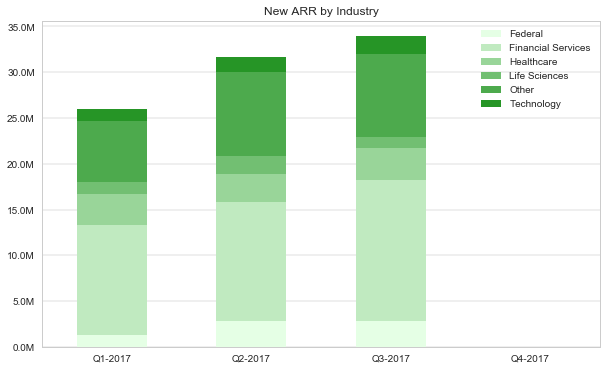

In [67]:
# create ticklabel formatter - in millions
formatter = mtick.FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(10,6))
ind_arr_plt = qt_ind_ARR.plot(kind = 'bar', stacked = True, color = sns.light_palette('green',7), 
                              ax = ax, title = 'New ARR by Industry')
ax.yaxis.set_major_formatter(formatter)
ax.yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
ax.xaxis.grid(False)
ind_arr_plt.set_ylabel('')
xticks = [item.get_text() for item in ind_arr_plt.get_xticklabels()]
xticks = [i[4:6] + '-' + str(i[0:4]) for i in xticks]
ind_arr_plt.set_xticklabels(labels= xticks, rotation = 0)
ind_arr_plt.legend(loc =1, fancybox=True, ncol=1)
plt.show(fig)

In [68]:
qt_leads_direct_sales

,Seminar/Conference,Website,Content Syndication,Paid Search,Webinar,Email,Field Event,Social Media,Other
2017Q1,230,498,790,274,278,7,35,0,5
2017Q2,1046,777,1164,525,679,82,60,3,11
2017Q3,297,780,1270,756,1120,12,13,30,1428
2017Q4,0,0,0,0,0,0,0,0,0


#### 2 - Number of Leads by Lead Source:

* a. All marketing leads

* b. Direct Sales Marketing leads

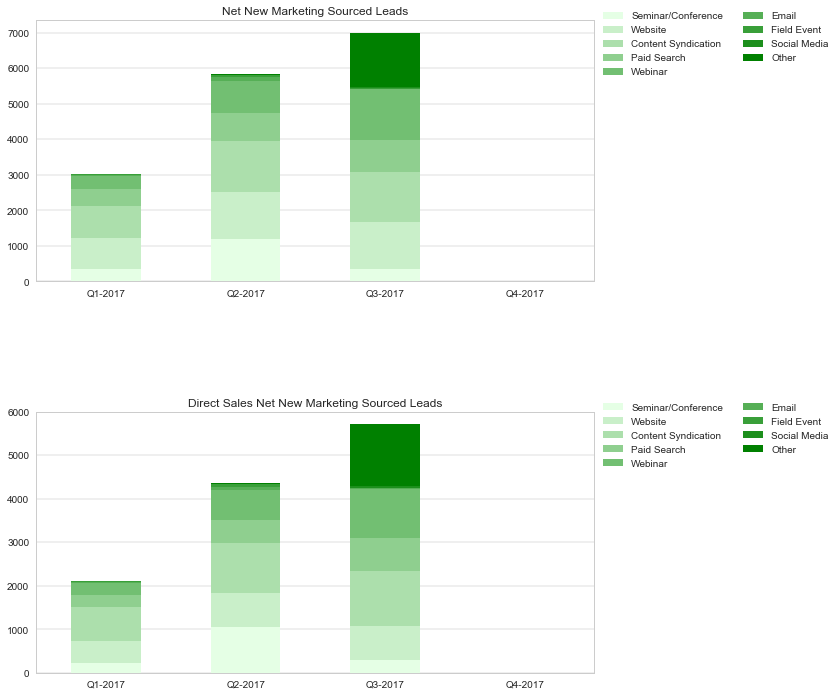

In [69]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize= (10,12), sharey = False)
fig.subplots_adjust(hspace=.5, wspace=.5)

mk_leads_plt = qt_leads_source.plot(kind = 'bar', stacked = True, color = sns.light_palette('green',9), 
                                    ax = axes[0], title = 'Net New Marketing Sourced Leads')
mk_salesdirected_plt = qt_leads_direct_sales.plot(kind = 'bar', stacked = True, color = sns.light_palette('green',9), 
    ax = axes[1], title = 'Direct Sales Net New Marketing Sourced Leads', legend=False)

# update tick labels
xticks = [item.get_text() for item in mk_leads_plt.get_xticklabels()]
xticks = [i[4:6] + '-' + str(i[0:4]) for i in xticks]
axes[0].set_xticklabels(labels= xticks, rotation = 0)
axes[1].set_xticklabels(labels= xticks, rotation = 0)
# update legend
axes[0].legend(loc = 3,bbox_to_anchor=(1.0, .750), ncol=2)
axes[1].legend(loc = 3,bbox_to_anchor=(1.0, .750), ncol=2)
# update grid
axes[0].yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
axes[1].yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
axes[0].xaxis.grid(False)
axes[1].xaxis.grid(False)
plt.show(fig)

#### 3 - Number of SQLs - Sales Sourced vs. Marketing Sourced

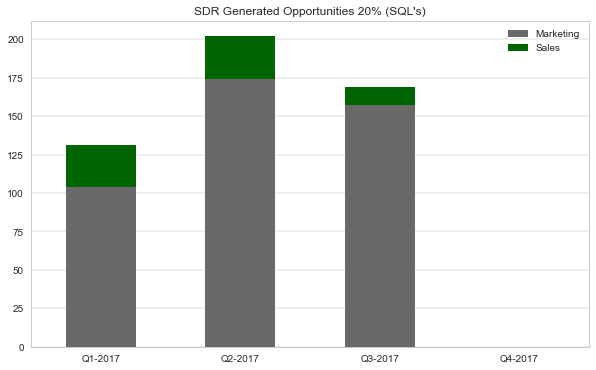

In [70]:
cols = ['dimgray','darkgreen'] 
fig, ax = plt.subplots(figsize=(10,6))

sql_plt = qt_sql.plot(kind = 'bar', stacked = True, color = cols,#sns.light_palette('green',2), 
                              ax = ax, title = "SDR Generated Opportunities 20% (SQL's)")
#ax.yaxis.set_major_formatter(formatter)
ax.yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
ax.xaxis.grid(False)
sql_plt.set_ylabel('')
xticks = [item.get_text() for item in sql_plt.get_xticklabels()]
xticks = [i[4:6] + '-' + str(i[0:4]) for i in xticks]
sql_plt.set_xticklabels(labels= xticks, rotation = 0)
sql_plt.legend(loc =1, fancybox=True, ncol=1)
plt.show(fig)

#### 4 - a. Quarterly Number of Open Opportunities by Stage

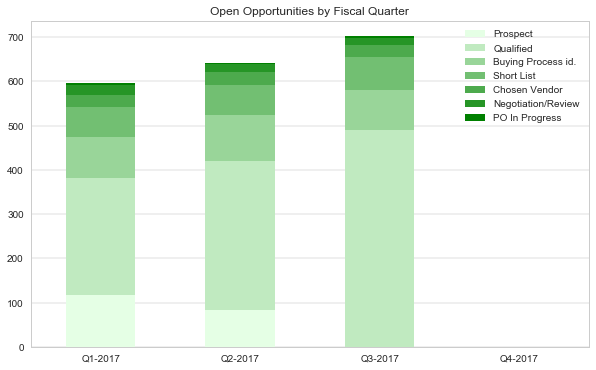

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
num_opps_plt = qt_stage_opp.plot(kind = 'bar', stacked = True, color = sns.light_palette('green',7), 
                            ax = ax, title = 'Open Opportunities by Fiscal Quarter')

num_opps_plt.set_ylabel('')
# change grid lines
ax.yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
ax.xaxis.grid(False)
# change x-axis labels
xticks = [item.get_text() for item in sql_plt.get_xticklabels()]
num_opps_plt.set_xticklabels(labels= xticks, rotation = 0)
num_opps_plt.legend(loc =0)
plt.show(fig)

#### 4 - b. Quarterly ARR in Open Pipeline by Stage

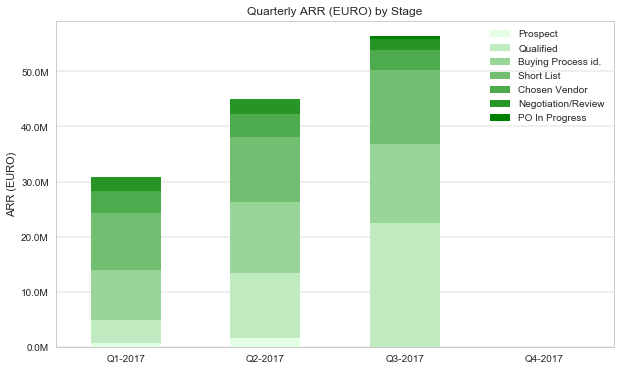

In [72]:
# create ticklabel formatter - in millions
formatter = mtick.FuncFormatter(millions)

fig, ax = plt.subplots(figsize=(10,6))
arr_plt = qt_stage_ARR.plot(kind = 'bar', stacked = True, color = sns.light_palette('green',7), ax = ax, title = 'Quarterly ARR (EURO) by Stage')
ax.yaxis.set_major_formatter(formatter)
arr_plt.set_ylabel('ARR (EURO)')
# update tick labels
xticks = [item.get_text() for item in arr_plt.get_xticklabels()]
xticks = [i[4:6] + '-' + str(i[0:4]) for i in xticks]
arr_plt.set_xticklabels(labels= xticks, rotation = 0)
# update grid
ax.yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
ax.xaxis.grid(False)
arr_plt.legend(loc =0)
plt.show(fig)

#### 5 - Quarterly Closed Won ARR by Industry

In [73]:
qt_ind_ARR_closed

,Federal,Financial Services,Healthcare,Life Sciences,Other,Technology
2017Q1,0.0,2117753.52,464686.94,0.0,260878.38,0.00
2017Q2,0.0,1396555.11,136785.68,0.0,908620.37,276090.56
2017Q3,0.0,1145457.23,306530.83,0.0,487327.57,29919.77
2017Q4,0.0,0.00,0.00,0.0,0.00,0.00


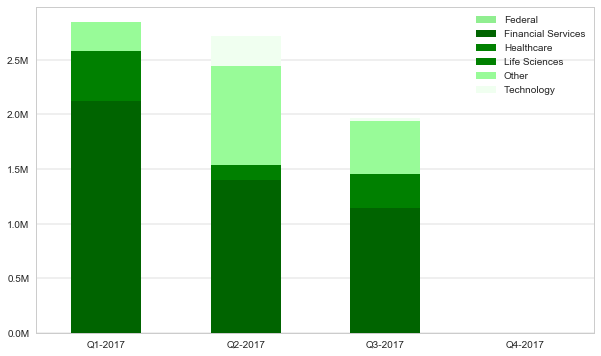

In [74]:
# create ticklabel formatter - in millions
formatter = mtick.FuncFormatter(millions)

cols = ['lightgreen','darkgreen','green','g','palegreen','honeydew']
#cols = ['darkgreen', 'palegreen','limegreen','green','mediumseagreen','seagreen'] 

fig, ax = plt.subplots(figsize=(10,6))
arr_closed_plt = qt_ind_ARR_closed.plot(kind = 'bar', stacked = True, color = cols, ax = ax) 
ax.yaxis.set_major_formatter(formatter)
arr_closed_plt.set_ylabel('')
# update tick labels
xticks = [item.get_text() for item in arr_closed_plt.get_xticklabels()]
xticks = [i[4:6] + '-' + str(i[0:4]) for i in xticks]
arr_closed_plt.set_xticklabels(labels= xticks, rotation = 0)
# update grid
ax.yaxis.grid(which='major', color='gray', linestyle='-', linewidth=.25)
ax.xaxis.grid(False)
arr_closed_plt.legend(loc =0)

plt.savefig(img_path + 'arr_closed_plt.png', format = 'png')
plt.show(fig)